In [1]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tqdm

gc.collect()

0

In [2]:
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'


BASELINE = 0.160384

In [3]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos (10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.1))
parquet_files_train = parquet_files_train[:num_files_train]

try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos")
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')

# Computar a Pandas
train_df = train_ddf.compute(scheduler='synchronous')
print(f"✓ Train shape: {train_df.shape}")

✓ Train cargado con 14 archivos
✓ Train shape: (2104266, 62)
✓ Train shape: (2104266, 62)


In [4]:
# Preprocesar columnas con listas - SUMAR todos los valores
import ast

columns_to_sum = [
    'iap_revenue_usd_bundle',
    'num_buys_bundle',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank',
    'whale_users_bundle_revenue_prank'
]

print("=" * 60)
print("PREPROCESANDO COLUMNAS CON LISTAS")
print("=" * 60)

def sum_values(x):
    """Suma todos los valores numéricos de la lista"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    try:
        # Si es string, convertir a lista
        if isinstance(x, str):
            x = ast.literal_eval(x)
        
        # Si es lista de tuplas, sumar el segundo valor de cada tupla
        if isinstance(x, list) and len(x) > 0:
            total = sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1])
            return total
        return 0
    except:
        return 0

for col in columns_to_sum:
    if col in train_df.columns:
        print(f"\n📊 Procesando {col}...")
        
        # Aplicar transformación
        train_df[col] = train_df[col].apply(sum_values)
        
        # Verificar resultado
        print(f"  ✓ Convertido a numérico")
        print(f"  Tipo nuevo: {train_df[col].dtype}")
        print(f"  Valores ejemplo: {train_df[col].head(3).values}")
        print(f"  Stats: min={train_df[col].min():.4f}, max={train_df[col].max():.4f}, mean={train_df[col].mean():.4f}")
    else:
        print(f"\n❌ {col} - NO ENCONTRADA")

print("\n" + "=" * 60)
print("✓ PREPROCESAMIENTO COMPLETADO")
print("=" * 60)

PREPROCESANDO COLUMNAS CON LISTAS

📊 Procesando iap_revenue_usd_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Procesando whale_users_bundle_num_buys_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Proces

In [5]:
# Definir features categóricas
cat_features = [
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
    'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
]

labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]

cat_features = [c for c in cat_features if c in train_df.columns]

# Label Encoding para categorías
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# Features numéricas
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude and c not in cat_features
    and train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Features finales
features = numeric_features + cat_features
print(f"Total features: {len(features)}")

Total features: 24


In [6]:
# Split temporal - validación solo del día 2025-10-06
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

# Usar solo el día 2025-10-06 para validación
val_date = pd.Timestamp('2025-10-06', tz='UTC')
val_mask = train_df['datetime'].dt.date == val_date.date()

X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Target
y_train = train_df[~val_mask]['iap_revenue_d7']
y_val = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Fecha máxima dataset: {train_df['datetime'].max()}")
print(f"Fecha validación: {val_date.date()}")
print(f"Train: {len(X_train):,} samples ({train_df[~val_mask]['datetime'].min()} a {train_df[~val_mask]['datetime'].max()})")
print(f"Val: {len(X_val):,} samples ({train_df[val_mask]['datetime'].min()} a {train_df[val_mask]['datetime'].max()})")
print(f"Val es solo día 2025-10-06: {train_df[val_mask]['datetime'].dt.date.nunique() == 1}")

/tmp/ipykernel_319435/2954038451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Fecha máxima dataset: 2025-10-06 13:00:00+00:00
Fecha validación: 2025-10-06
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True


In [7]:
# Preprocesar datos
for col in X_train.select_dtypes(include=['object']).columns:
    if col not in cat_features:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("✓ Datos preprocesados")

✓ Datos preprocesados


In [8]:
# PARÁMETROS OPTIMIZADOS PARA XGBOOST
params_optimized = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 20,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'tree_method': 'hist',
    'device': 'cpu',
    'verbosity': 1
}

print("=" * 60)
print("ENTRENANDO MODELO XGBOOST OPTIMIZADO")
print("=" * 60)
print("Parámetros:")
print(f"  Learning rate: {params_optimized['learning_rate']}")
print(f"  Max depth: {params_optimized['max_depth']}")
print(f"  Min child weight: {params_optimized['min_child_weight']}")
print(f"  Subsample: {params_optimized['subsample']}")
print(f"  Colsample bytree: {params_optimized['colsample_bytree']}")
print("=" * 60)

ENTRENANDO MODELO XGBOOST OPTIMIZADO
Parámetros:
  Learning rate: 0.01
  Max depth: 8
  Min child weight: 20
  Subsample: 0.7
  Colsample bytree: 0.7


In [9]:
# Entrenar modelo XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_log, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val_log, enable_categorical=True)

evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params_optimized,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=50
)

print(f"\n✓ Modelo XGBoost entrenado ({model.best_iteration} iteraciones)")

[0]	train-rmse:0.44062	val-rmse:0.45210
[50]	train-rmse:0.41266	val-rmse:0.42608
[50]	train-rmse:0.41266	val-rmse:0.42608
[100]	train-rmse:0.39803	val-rmse:0.41320
[100]	train-rmse:0.39803	val-rmse:0.41320
[150]	train-rmse:0.39066	val-rmse:0.40730
[150]	train-rmse:0.39066	val-rmse:0.40730
[200]	train-rmse:0.38626	val-rmse:0.40434
[200]	train-rmse:0.38626	val-rmse:0.40434
[250]	train-rmse:0.38335	val-rmse:0.40282
[250]	train-rmse:0.38335	val-rmse:0.40282
[300]	train-rmse:0.38136	val-rmse:0.40199
[300]	train-rmse:0.38136	val-rmse:0.40199
[350]	train-rmse:0.37987	val-rmse:0.40158
[350]	train-rmse:0.37987	val-rmse:0.40158
[400]	train-rmse:0.37866	val-rmse:0.40128
[400]	train-rmse:0.37866	val-rmse:0.40128
[450]	train-rmse:0.37765	val-rmse:0.40111
[450]	train-rmse:0.37765	val-rmse:0.40111
[500]	train-rmse:0.37679	val-rmse:0.40094
[500]	train-rmse:0.37679	val-rmse:0.40094
[550]	train-rmse:0.37599	val-rmse:0.40084
[550]	train-rmse:0.37599	val-rmse:0.40084
[600]	train-rmse:0.37522	val-rmse:0.40

In [ ]:
# Evaluar en validación

from time import time


start_time = time()
dval_pred = xgb.DMatrix(X_val, enable_categorical=True)
pred_log = model.predict(dval_pred)
pred = np.expm1(pred_log).clip(0, None)

end_time = time()
elapsed_time = end_time - start_time

print(f"Tiempo de predicción en validación: {elapsed_time:.2f} segundos")
msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)

print("=" * 60)
print("RESULTADOS EN VALIDACIÓN (XGBOOST)")
print("=" * 60)
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

Tiempo de predicción en validación: 2.29 segundos
RESULTADOS EN VALIDACIÓN (XGBOOST)
MSLE: 0.160197
RMSE: $330317.43
Revenue promedio predicho: $0.12
Revenue promedio real: $2.67


: 

In [11]:
"""# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS
from sklearn.model_selection import ParameterGrid
import time

print("=" * 60)
print("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# Definir grid de parámetros
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 15],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9]
}

# Base params
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Preparar datasets
cat_features_valid = [col for col in cat_features if col in features]
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

# Grid search
results = []
best_score = float('inf')
best_params = None

grid = list(ParameterGrid(param_grid))
print(f"\nTotal combinaciones a probar: {len(grid)}")
print("Probando combinaciones (esto puede tardar)...\n")

for i, params in enumerate(grid[:20], 1):  # Limitar a 20 combinaciones para no tardar mucho
    print(f"[{i}/20] Probando: lr={params['learning_rate']}, leaves={params['num_leaves']}, depth={params['max_depth']}")
    
    # Combinar params
    current_params = {**base_params, **params}
    
    # Entrenar
    start_time = time.time()
    model_temp = lgb.train(
        current_params,
        train_ds,
        num_boost_round=500,  # Reducido para grid search
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    elapsed = time.time() - start_time
    
    # Evaluar
    pred_log = model_temp.predict(X_val)
    pred = np.expm1(pred_log).clip(0, None)
    msle = mean_squared_log_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    # Guardar resultado
    results.append({
        **params,
        'msle': msle,
        'rmse': rmse,
        'best_iteration': model_temp.best_iteration,
        'time': elapsed
    })
    
    print(f"  ✓ MSLE: {msle:.6f} | RMSE: {rmse:.2f} | Iters: {model_temp.best_iteration} | Time: {elapsed:.1f}s")
    
    # Actualizar mejor
    if msle < best_score:
        best_score = msle
        best_params = params
        print(f"  🎯 NUEVO MEJOR SCORE!")
    
    print()

# Mostrar resultados
print("=" * 60)
print("RESULTADOS GRID SEARCH")
print("=" * 60)

results_df = pd.DataFrame(results).sort_values('msle')
print("\nTop 5 mejores combinaciones:")
print(results_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("MEJORES PARÁMETROS ENCONTRADOS:")
print("=" * 60)
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nMejor MSLE: {best_score:.6f}")
print("=" * 60)

# Entrenar modelo final con mejores params
print("\nEntrenando modelo final con mejores parámetros...")
final_params = {**base_params, **best_params}

model_final = lgb.train(
    final_params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"✓ Modelo final entrenado ({model_final.best_iteration} iteraciones)")

# Evaluar modelo final
pred_log = model_final.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)
msle_final = mean_squared_log_error(y_val, pred)
rmse_final = np.sqrt(mean_squared_error(y_val, pred))

print("\n" + "=" * 60)
print("RESULTADOS FINALES CON MEJORES PARÁMETROS")
print("=" * 60)
print(f"MSLE: {msle_final:.6f}")
print(f"RMSE: ${rmse_final:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

# Guardar modelo final
model = model_final"""

'# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS\nfrom sklearn.model_selection import ParameterGrid\nimport time\n\nprint("=" * 60)\nprint("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")\nprint("=" * 60)\n\n# Definir grid de parámetros\nparam_grid = {\n    \'learning_rate\': [0.01, 0.03, 0.05],\n    \'num_leaves\': [31, 63, 127],\n    \'max_depth\': [-1, 10, 15],\n    \'min_data_in_leaf\': [20, 50, 100],\n    \'feature_fraction\': [0.7, 0.8, 0.9],\n    \'bagging_fraction\': [0.7, 0.8, 0.9]\n}\n\n# Base params\nbase_params = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'bagging_freq\': 5,\n    \'verbose\': -1,\n    \'device\': \'cpu\'\n}\n\n# Preparar datasets\ncat_features_valid = [col for col in cat_features if col in features]\ntrain_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)\nval_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)\n\n# Grid search\nresults = []\nbest_score = float(\'inf\')\nbest_params = None

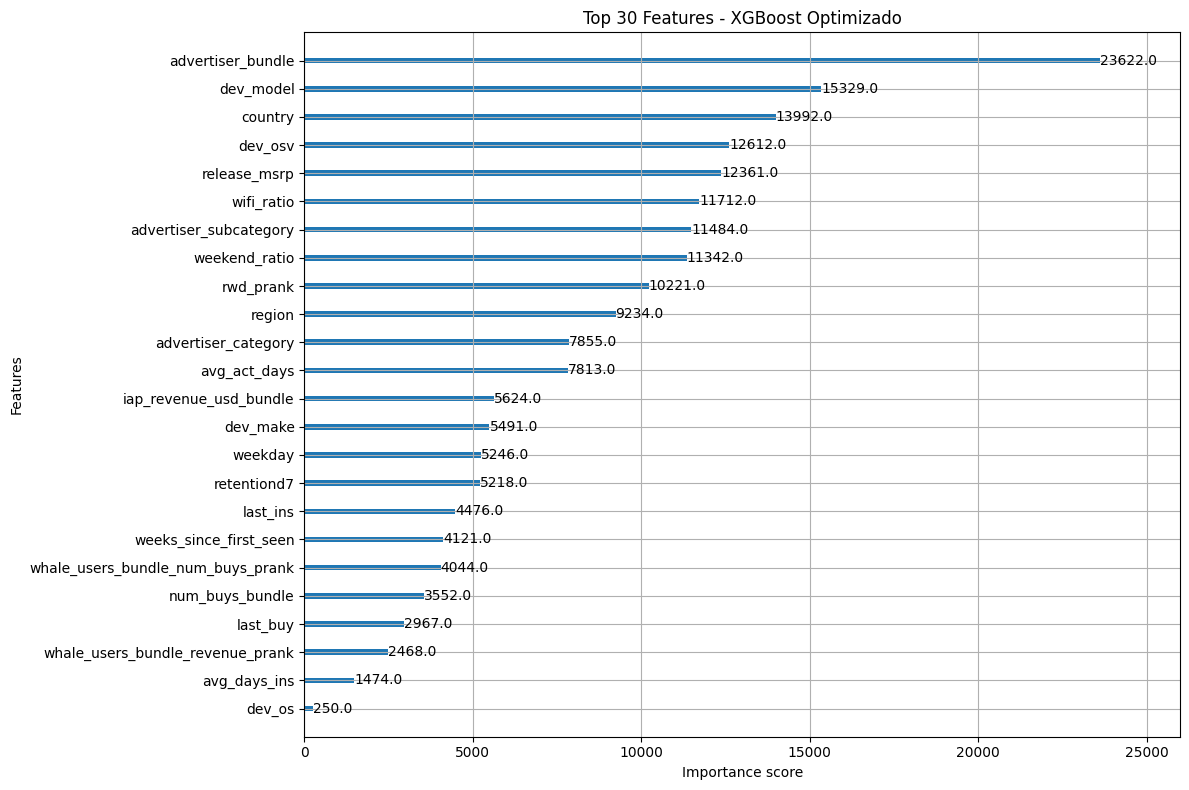

In [12]:
# Feature importance XGBoost
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - XGBoost Optimizado')
plt.tight_layout()
plt.show()

In [13]:
import time

TEST_PATH = "/home/stargix/Desktop/hackathons/datathon/test/test"

print("=" * 60)
print("GENERANDO PREDICCIONES EN TEST (XGBOOST OPTIMIZADO)")
print("=" * 60)

# Repartir parquet en bloques pequeños y obtener delayed parts
test_meta = dd.read_parquet(TEST_PATH, engine="pyarrow", index=False).head(0)
available_cols = [c for c in ["row_id"] + features if c in test_meta.columns]

dd_test = dd.read_parquet(
    TEST_PATH,
    engine="pyarrow",
    columns=available_cols,
    blocksize="128MB"
)
dd_test = dd_test.repartition(npartitions=384)
delayed_parts = dd_test.to_delayed()
print(f"Chunks repartidos: {len(delayed_parts)}\n")

# Preparar ayudas vectorizadas
columns_to_sum = [
    "iap_revenue_usd_bundle", "num_buys_bundle", "rwd_prank",
    "whale_users_bundle_num_buys_prank", "whale_users_bundle_revenue_prank"
]
le_maps = {
    col: {cls: idx for idx, cls in enumerate(enc.classes_)}
    for col, enc in label_encoders.items()
}

def sum_list_series(series: pd.Series) -> pd.Series:
    return series.apply(
        lambda x: sum(item[1] for item in x if isinstance(item, tuple) and len(item) > 1)
        if isinstance(x, list) else 0
    )

pred_dfs = []

for i, delayed_part in enumerate(delayed_parts, 1):
    t0 = time.perf_counter()
    part_df = delayed_part.compute()
    row_ids = part_df["row_id"].values

    X_part = part_df.reindex(columns=features, fill_value=0)

    for col in columns_to_sum:
        if col in X_part.columns:
            X_part[col] = sum_list_series(X_part[col])

    numeric_cols = [col for col in numeric_features if col in X_part.columns]
    if numeric_cols:
        X_part[numeric_cols] = X_part[numeric_cols].apply(pd.to_numeric, errors="coerce")
        X_part[numeric_cols] = X_part[numeric_cols].fillna(0)

    for col in cat_features:
        if col in X_part.columns:
            mapped = (
                X_part[col].astype(str)
                .map(le_maps[col])
                .fillna(-1)
                .astype("int16")
            )
            X_part[col] = mapped.astype('category')

    # Predicción con XGBoost
    dtest_part = xgb.DMatrix(X_part, enable_categorical=True)
    pred_log = model.predict(dtest_part)
    pred = np.expm1(pred_log).clip(0, None)

    pred_dfs.append(pd.DataFrame({"row_id": row_ids, "iap_revenue_d7": pred}))

    print(f"[{i}/{len(delayed_parts)}] {len(row_ids):,} filas | {time.perf_counter() - t0:.1f}s")
    del part_df, X_part, dtest_part, pred_log, pred, row_ids
    gc.collect()

print("=" * 60)
print("FINALIZANDO SUBMISSION")
print("=" * 60)

submission = pd.concat(pred_dfs, ignore_index=True)

print(f"Total filas: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaNs: {submission['iap_revenue_d7'].isna().sum()}")
print("\nEstadísticas predicciones:")
print(submission['iap_revenue_d7'].describe())

submission_path = "/home/stargix/Desktop/hackathons/datathon/submission_xgboost.csv"
submission.to_csv(submission_path, index=False)
print(f"\n✓ Guardado en: {submission_path}")
print("=" * 60)

submission.head(10)

GENERANDO PREDICCIONES EN TEST (XGBOOST OPTIMIZADO)
Chunks repartidos: 384

Chunks repartidos: 384



XGBoostError: [04:12:42] /workspace/src/data/../data/cat_container.h:28: Invalid new DataFrame input for the: 15th feature (0-based). The data type doesn't match the one used in the training dataset. Both should be either numeric or categorical. For a categorical feature, the index type must match between the training and test set.
Stack trace:
  [bt] (0) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2bdf8c) [0x7503c72bdf8c]
  [bt] (1) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x609430) [0x7503c7609430]
  [bt] (2) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x61dc76) [0x7503c761dc76]
  [bt] (3) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x8bea3f) [0x7503c78bea3f]
  [bt] (4) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x9134a2) [0x7503c79134a2]
  [bt] (5) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x91b036) [0x7503c791b036]
  [bt] (6) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x6a2f82) [0x7503c76a2f82]
  [bt] (7) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x6f5940) [0x7503c76f5940]
  [bt] (8) /home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x2df) [0x7503c71ce67f]

